<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 12: Reinforcement Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 12 Video Material

* Part 12.1: Introduction to the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=_KbUxgyisjM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb)
* Part 12.2: Introduction to Q-Learning [[Video]](https://www.youtube.com/watch?v=A3sYFcJY3lA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_02_qlearningreinforcement.ipynb)
* Part 12.3: Keras Q-Learning in the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=qy1SJmsRhvM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_03_keras_reinforce.ipynb)
* **Part 12.4: Atari Games with Keras Neural Networks** [[Video]](https://www.youtube.com/watch?v=co0SwPWoZh0&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb)
* Part 12.5: Application of Reinforcement Learning [[Video]](https://www.youtube.com/watch?v=1jQPP3RfwMI&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_05_apply_rl.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow, and has the necessary Python libraries installed.

In [1]:
# HIDE OUTPUT
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q ale-py
  !pip install -q 'gym==0.17.3'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q 'tf-agents==0.12.0'

Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 0s (7,462 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selectin

# Part 12.4: Atari Games with Keras Neural Networks

The Atari 2600 is a home video game console from Atari, Inc., Released on September 11, 1977. Most credit the Atari with popularizing microprocessor-based hardware and games stored on ROM cartridges instead of dedicated hardware with games built into the unit. Atari bundled their console with two joystick controllers, a conjoined pair of paddle controllers, and a game cartridge: initially [Combat](https://en.wikipedia.org/wiki/Combat_(Atari_2600)), and later [Pac-Man](https://en.wikipedia.org/wiki/Pac-Man_(Atari_2600)).

Atari emulators are popular and allow gamers to play many old Atari video games on modern computers. These emulators are even available as JavaScript.

* [Virtual Atari](http://www.virtualatari.org/listP.html)

Atari games have become popular benchmarks for AI systems, particularly reinforcement learning. OpenAI Gym internally uses the [Stella Atari Emulator](https://stella-emu.github.io/). You can see the Atari 2600 in Figure 12.ATARI.

**Figure 12.ATARI: The Atari 2600**
![Atari 2600 Console](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/atari-1.png "Atari 2600 Console")

## Actual Atari 2600 Specs

* CPU: 1.19 MHz MOS Technology 6507
* Audio + Video processor: Television Interface Adapter (TIA)
* Playfield resolution: 40 x 192 pixels (NTSC). It uses a 20-pixel register that is mirrored or copied, left side to right side, to achieve the width of 40 pixels.
* Player sprites: 8 x 192 pixels (NTSC). Player, ball, and missile sprites use pixels 1/4 the width of playfield pixels (unless stretched).
* Ball and missile sprites: 1 x 192 pixels (NTSC).
* Maximum resolution: 160 x 192 pixels (NTSC). Max resolution is achievable only with programming tricks that combine sprite pixels with playfield pixels.
* 128 colors (NTSC). 128 possible on screen. Max of 4 per line: background, playfield, player0 sprite, and player1 sprite. Palette switching between lines is common. Palette switching mid-line is possible but not common due to resource limitations.
* 2 channels of 1-bit monaural sound with 4-bit volume control.

## OpenAI Lab Atari Pong

You can use OpenAI Gym with Windows; however, it requires a special [installation procedure](https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30). 

This chapter demonstrates playing [Atari Pong](https://github.com/wau/keras-rl2/blob/master/examples/dqn_atari.py). Pong is a two-dimensional sports game that simulates table tennis. The player controls an in-game paddle by moving it vertically across the left or right side of the screen. They can compete against another player controlling a second paddle on the opposing side. Players use the paddles to hit a ball back and forth. The goal is for each player to reach eleven points before the opponent; you earn points when one fails to return it to the other. For the Atari 2600 version of Pong, a computer player (controlled by the Atari 2600) is the opposing player.

This section shows how to adapt TF-Agents to an Atari game. You can quickly adapt this example to any Atari game by simply changing the environment name. However, I tuned the code presented here for Pong, and it may not perform as well for other games. Some tuning will likely be necessary to produce a good agent for other games. Compared to the pole-cart game presented earlier in this chapter, some changes are required.

We begin by importing the needed Python packages.

In [2]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.environments import batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


## Hyperparameters

The hyperparameter names are the same as the previous DQN example; however, I tuned the numeric values for the more complex Atari game.

In [4]:
# 10K already takes awhile to complete, with minimal results.
# To get an effective agent requires much more.
num_iterations = 10000

initial_collect_steps = 200
collect_steps_per_iteration = 10
replay_buffer_max_length = 100000

batch_size = 32
learning_rate = 2.5e-3
log_interval = 1000

num_eval_episodes = 5
eval_interval = 25000


The algorithm needs more iterations for an Atari game. I also found that increasing the number of collection steps helped the algorithm train.

## Atari Environment

You must handle Atari environments differently than games like cart-poll. Atari games typically use their 2D displays as the environment state. AI Gym represents Atari games as either a 3D (height by width by color) state spaced based on their screens or a vector representing the game's computer RAM state. To preprocess Atari games for greater computational efficiency, we skip several frames, decrease the resolution, and discard color information. The following code shows how we can set up an Atari environment.

In [5]:
# HIDE OUTPUT
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e -o+ /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

--2022-04-02 18:47:11--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.68M  4.78MB/s    in 3.9s    

2022-04-02 18:47:15 (4.76 MB/s) - ‘Roms.rar’ saved [19583716/19583716]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  /content/ROM/128 in 1 Game Select ROM (Unknown) ~.bin          0%  OK 
Extracting  /content/ROM/2 in 1 - Chess, Othello (Atari) (Prototype).bin       0%  OK 
Extracting  /content/ROM/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) (PAL).bin       0%  OK 
Extracting  /content/ROM/2 Pak Special - Challenge, Surfing (1990) (HES) (771-333) (PAL).

In [6]:
#env_name = 'Breakout-v4'
env_name = 'Pong-v0'
#env_name = 'BreakoutDeterministic-v4'
#env = suite_gym.load(env_name)

# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4

max_episode_frames=108000  # ALE frames

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
#env = batched_py_environment.BatchedPyEnvironment([env])

/usr/local/lib/python3.7/dist-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()
/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


We can now reset the environment and display one step.  The following image shows how the Pong game environment appears to a user.

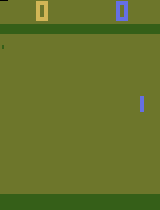

In [7]:
env.reset()
PIL.Image.fromarray(env.render())


We are now ready to load and wrap the two environments for TF-Agents. The algorithm uses the first environment for evaluation and the second to train.

In [8]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Agent

I used the following code from the TF-Agents examples to wrap up the regular Q-network class.  The AtariQNetwork class ensures that the pixel values from the Atari screen are divided by 255.  This division assists the neural network by normalizing the pixel values between 0 and 1.

In [9]:
# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4


class AtariCategoricalQNetwork(network.Network):
    """CategoricalQNetwork subclass that divides observations by 255."""

    def __init__(self, input_tensor_spec, action_spec, **kwargs):
        super(AtariCategoricalQNetwork, self).__init__(
            input_tensor_spec, state_spec=())
        input_tensor_spec = tf.TensorSpec(
            dtype=tf.float32, shape=input_tensor_spec.shape)
        self._categorical_q_network = \
            categorical_q_network.CategoricalQNetwork(
                input_tensor_spec, action_spec, **kwargs)

    @property
    def num_atoms(self):
        return self._categorical_q_network.num_atoms

    def call(self, observation, step_type=None, network_state=()):
        state = tf.cast(observation, tf.float32)
        # We divide the grayscale pixel values by 255 here rather than
        # storing normalized values beause uint8s are 4x cheaper to
        # store than float32s.
        # TODO(b/129805821): handle the division by 255 for
        # train_eval_atari.py in
        # a preprocessing layer instead.
        state = state / 255
        return self._categorical_q_network(
            state, step_type=step_type, network_state=network_state)


Next, we introduce two hyperparameters specific to the neural network we are about to define.

In [10]:
fc_layer_params = (512,)
conv_layer_params = ((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariCategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


Convolutional neural networks usually comprise several alternating pairs of convolution and max-pooling layers, ultimately culminating in one or more dense layers. These layers are the same types as previously seen in this course. The **QNetwork** accepts two parameters that define the convolutional neural network structure. 

The more simple of the two parameters is **fc_layer_params**. This parameter specifies the size of each of the dense layers. A tuple specifies the size of each of the layers in a list. 

The second parameter, named **conv_layer_params**, is a list of convolution layers parameters, where each item is a length-three tuple indicating (filters, kernel_size, stride). This implementation of QNetwork supports only convolution layers. If you desire a more complex convolutional neural network, you must define your variant of the **QNetwork**.

The **QNetwork** defined here is not the agent. Instead, the **QNetwork** is used by the DQN agent to implement the actual neural network. This technique allows flexibility as you can set your class if needed.

Next, we define the optimizer. For this example, I used RMSPropOptimizer. However, AdamOptimizer is another popular choice. We also created the DQN agent and referenced the Q-network.

In [11]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period = 32000  # ALE frames
update_period = 16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP


agent = categorical_dqn_agent.CategoricalDqnAgent(
    time_step_spec,
    action_spec,
    categorical_q_network=q_net,
    optimizer=optimizer,
    # epsilon_greedy=epsilon,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False)

agent.initialize()


## Metrics and Evaluation

There are many different ways to measure the effectiveness of a model trained with reinforcement learning. The loss function of the internal Q-network is not a good measure of the entire DQN algorithm's overall fitness. The network loss function measures how close the Q-network fits the collected data and does not indicate how effectively the DQN maximizes rewards. The method used for this example tracks the average reward received over several episodes.

In [16]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of
# different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics


## Replay Buffer

DQN works by training a neural network to predict the Q-values for every possible environment state. A neural network needs training data, so the algorithm accumulates this training data as it runs episodes. The replay buffer is where this data is stored. Only the most recent episodes are stored; older episode data rolls off the queue as the queue accumulates new data.

In [17]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


## Random Collection

The algorithm must prime the pump.  Training cannot begin on an empty replay buffer.  The following code performs a predefined number of steps to generate initial training data.

In [18]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())


def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step,\
                                      next_time_step)

    # Add trajectory to the replay buffer
    buffer.add_batch(traj)


def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)


collect_data(train_env, random_policy, replay_buffer,
             steps=initial_collect_steps)


## Training the Agent

We are now ready to train the DQN. Depending on how many episodes you wish to run through, this process can take many hours. This code will update both the loss and average return as training occurs. As training becomes more successful, the average return should increase. The losses reported reflecting the average loss for individual training batches.

In [19]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy,
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and 
    # save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)

    # Sample a batch of data from the buffer and 
    # update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy,
                                        num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


step = 1000: loss = 3.9279017448425293
step = 2000: loss = 3.9280214309692383
step = 3000: loss = 3.924931526184082
step = 4000: loss = 3.9209065437316895
step = 5000: loss = 3.919551134109497
step = 6000: loss = 3.919588327407837
step = 7000: loss = 3.9074008464813232
step = 8000: loss = 3.8954014778137207
step = 9000: loss = 3.8865578174591064
step = 10000: loss = 3.895845890045166


## Videos

Perhaps the most compelling way to view an Atari game's results is a video that allows us to see the agent play the game. We now have a trained model and observed its training progress on a graph. The following functions are defined to watch the agent play the game in the notebook.

In [21]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    return embed_mp4(filename)


First, we will observe the trained agent play the game.

In [22]:
# HIDE OUTPUT
create_policy_eval_video(agent.policy, "trained-agent")


For comparison, we observe a random agent play.  While the trained agent is far from perfect, with enough training, it does outperform the random agent considerably.

In [24]:
# HIDE OUTPUT
create_policy_eval_video(random_policy, "random-agent")
